In [59]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf

from collections import Counter
from nltk.corpus import stopwords
from scipy import stats
from tensorflow.keras import losses, optimizers, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras import layers, Model

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# if new methods are created in referenced codes, run the following code.
%reload_ext autoreload

## 初始化参数

In [21]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr


output_path = os.path.abspath('./output')
data_name = 'spam_tf'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['ham', 'spam']

# 当binary_flag=True，auc的计算有些问题。回头有时间修复。
binary_flag=False
loss =  losses.SparseCategoricalCrossentropy(from_logits=True) if not binary_flag else losses.BinaryCrossentropy(from_logits=True)

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'Text',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 1000,
    'sequence_length': 64,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'binary_flag':binary_flag,
    'metrics':['accuracy', ], #, tf.keras.metrics.AUC(from_logits=True)
    'loss':loss,
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'pretrained_models' :{
        'bert_base_uncased':'bert-base-uncased',
    }, 
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()


2021-09-28 07:07:46,149: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/results.json


## 获取数据

In [4]:
print('-'*25, '读取数据', '-'*25)
df_spam = pd.read_csv("data/spam.csv",encoding='ISO-8859-1')
print(df_spam.shape)
display(df_spam.head(5))

------------------------- 读取数据 -------------------------
(5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 探索数据

### 数据清理

In [5]:
print('-'*25, '清理数据', '-'*25)
df_spam.drop(df_spam.columns[2:], axis=1, inplace=True)
df_spam=df_spam.dropna()                                                           
df_spam=df_spam.reset_index(drop=True) 
df_spam.columns = ["label", "text"]

display(df_spam.head(5))
print(df_spam.shape)
print(df_spam.groupby('label').size())

# 设置标签
df_spam['label'] = df_spam['label'].map({'ham':0,'spam':1})
display(df_spam.head(5))

print('-'*25, '生成训练测试数据', '-'*25)
texts = list(df_spam.text) 
labels = np.array(df_spam.label)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, 
                                                                      test_size=0.2,
                                                                      random_state=202109)
print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

------------------------- 清理数据 -------------------------


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


(5572, 2)
label
ham     4825
spam     747
dtype: int64


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


------------------------- 生成训练测试数据 -------------------------
train_texts.length=4457, train_labels.shape=(4457,)
test_texts.length=1115, test_labels.shape=(1115,)


### 类别分布

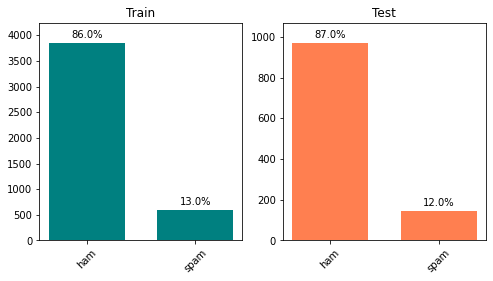

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)

### 文本长度分布

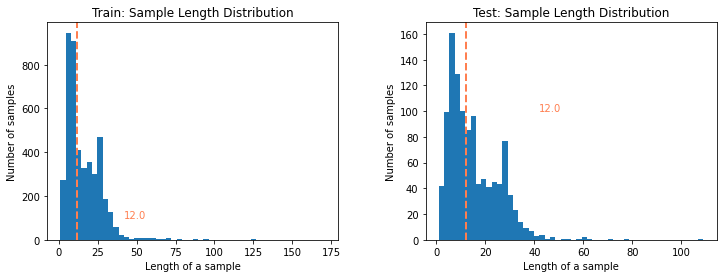

train：mean=15.55 variance=132.31
test：mean=15.26 variance=112.37


In [7]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [8]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,合计
,,,
test,1114,1,1115
train,4452,5,4457
合计,5566,6,5572


------------------------- Expected -------------------------


,0-99,100-199,合计
,,,
test,1113.799354,1.200646,1115.0
train,4452.200646,4.799354,4457.0
合计,5566.000000,6.000000,5572.0


然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [9]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 0.04196456841831607
critical_value = 3.841458820694124
p_value = 0.83768732631118


### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

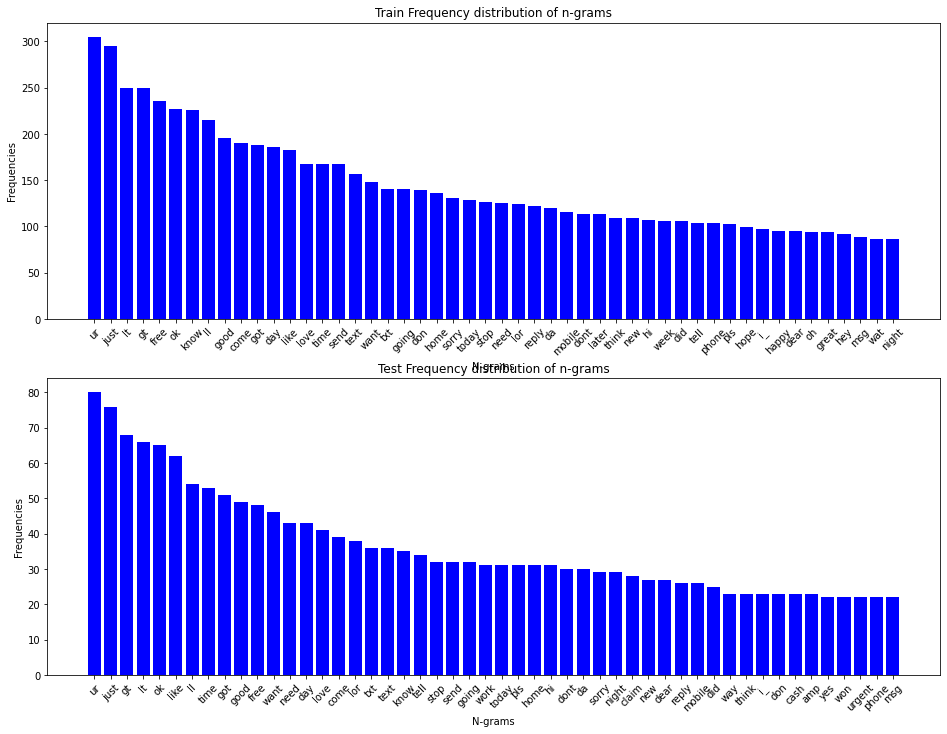

In [10]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [11]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<20: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 15585
Number of Vocabulary: 573


## 数据准备

### Sequence + Preprocess

In [25]:
generator = qtf.classification.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                                 texts=train_texts, max_features=params.max_features, 
                                                 max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [26]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 64) (32,)
---------------------------------------- ham ----------------------------------------
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 828  22 110  95 324 200  53] (64,)
---------------------------------------- spam ----------------------------------------
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  20  54  63  10  20   3 139 156   1  10
  22 855  58  39 106 414 939   9   1   8] (64,)
---------------------------------------- ham ----------------------------------------
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  

### Sequence + Process

In [27]:
generator = qtf.classification.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                                 standardize=qtf.text.standardize_tf_text1, 
                                                                 texts=train_texts, 
                                                                 max_features=params.max_features,
                                                                 max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [28]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 64) (32,)
---------------------------------------- ham ----------------------------------------
[ 69  18 298 919 524 227  38   2  19   3  47   3   6   1  10 135 494   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0] (64,)
---------------------------------------- ham ----------------------------------------
[572  26   2  61 661  30 460  94   2  59 974  16  77   3 562 804  94   2
 557  16   1  30   1   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0] (64,)
---------------------------------------- ham ----------------------------------------
[  1  30 698  41   3   1  54   5   1 432   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   

In [29]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-09-28 07:09:26,611: INFO: --------------------------------------------------------------------------------
2021-09-28 07:10:48,510: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-09-28 07:10:48,515: INFO: embedding_matrix.shape: (1000, 300)
2021-09-28 07:10:48,516: INFO: match count: 986
2021-09-28 07:10:48,517: INFO: missing word count: 14


### BERT + PreProcess

In [37]:
pretrained_model_name_or_path = params.pretrained_models.bert_base_uncased
generator = qtf.classification.BertGenerator('bert_preproces', 
                                             pretrained_model_name_or_path=pretrained_model_name_or_path,  
                                             max_sequence_length=params.sequence_length)
bert_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                             generator=generator, batch_size=params.batch_size) 

In [38]:
data, labels = iter(bert_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 64) (32,)
---------------------------------------- ham ----------------------------------------
[  101  4931  2017  2409  2115  2171  2000 11721 14317  3286  6289  1029
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0] (64,)
---------------------------------------- ham ----------------------------------------
[ 101 2074 3671 2069 2182 1024 1007  102    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] (64,)
---------------------------------------- spam --------------------------------------

In [43]:
generator.bert_tokenizer.max_model_input_sizes

{'bert-base-uncased': 512,
 'bert-large-uncased': 512,
 'bert-base-cased': 512,
 'bert-large-cased': 512,
 'bert-base-multilingual-uncased': 512,
 'bert-base-multilingual-cased': 512,
 'bert-base-chinese': 512,
 'bert-base-german-cased': 512,
 'bert-large-uncased-whole-word-masking': 512,
 'bert-large-cased-whole-word-masking': 512,
 'bert-large-uncased-whole-word-masking-finetuned-squad': 512,
 'bert-large-cased-whole-word-masking-finetuned-squad': 512,
 'bert-base-cased-finetuned-mrpc': 512,
 'bert-base-german-dbmdz-cased': 512,
 'bert-base-german-dbmdz-uncased': 512,
 'TurkuNLP/bert-base-finnish-cased-v1': 512,
 'TurkuNLP/bert-base-finnish-uncased-v1': 512,
 'wietsedv/bert-base-dutch-cased': 512}

## 模型

### Embedding

#### embedding1

In [33]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
# model = qtf.classification.text_models.embedding1(helper, name='embedding1', binary_flag=params.binary_flag)
# model.summary()
# history = helper.train(model)
# helper.model_summary(model, history=history)

#### embedding2

2021-09-28 07:13:50,370: INFO: model_params.embedding2.dropout=0.4
2021-09-28 07:13:50,371: INFO: model_params.embedding2.embedding_dim=200
2021-09-28 07:13:50,443: INFO: learning_rate=0.001
2021-09-28 07:13:50,444: INFO: model_params.embedding2.clip_value=None
2021-09-28 07:13:50,472: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2
2021-09-28 07:13:50,477: INFO: model_params.embedding2.epochs=15
2021-09-28 07:13:50,478: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2, monitor=val_accuracy)
2021-09-28 07:13:50,479: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-09-28 07:13:50,480: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-09-28 07:13:50,481: INFO: use LearningRateScheduler()
2021-09-28 07:13:50,482: INFO: steps_per_epoch=None
2021-09-28

TensorSpec(shape=(32, 64), dtype=tf.int64, name=None)
Model: "embedding2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 200)      200000      input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 200)          0           embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 200)          0           embedding[0][0]                  
___________________________________

2021-09-28 07:13:54,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


Epoch 2/15
139/139 [==============================] - 1s 6ms/step - loss: 0.1211 - accuracy: 0.9604 - val_loss: 0.0690 - val_accuracy: 0.9865
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


2021-09-28 07:13:56,105: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


Epoch 3/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0505 - accuracy: 0.9874 - val_loss: 0.0473 - val_accuracy: 0.9874
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


2021-09-28 07:13:57,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


Epoch 4/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0334 - accuracy: 0.9924 - val_loss: 0.0410 - val_accuracy: 0.9874
Epoch 5/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0245 - accuracy: 0.9939 - val_loss: 0.0386 - val_accuracy: 0.9883
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


2021-09-28 07:14:00,179: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2/assets


Epoch 6/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0186 - accuracy: 0.9948 - val_loss: 0.0380 - val_accuracy: 0.9883
Epoch 7/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.0383 - val_accuracy: 0.9883
Epoch 8/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0391 - val_accuracy: 0.9883
Epoch 9/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.0403 - val_accuracy: 0.9883
Epoch 10/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0070 - accuracy: 0.9991 - val_loss: 0.0416 - val_accuracy: 0.9883
Epoch 11/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0057 - accuracy: 0.9993 - val_loss: 0.0430 - val_accuracy: 0.9883
Epoch 12/15
139/139 [==============================] - 1s 6ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.0443 - val_accuracy: 0.9874
Epo

2021-09-28 07:14:08,310: INFO: finish training [elapsed time: 17.83 seconds]


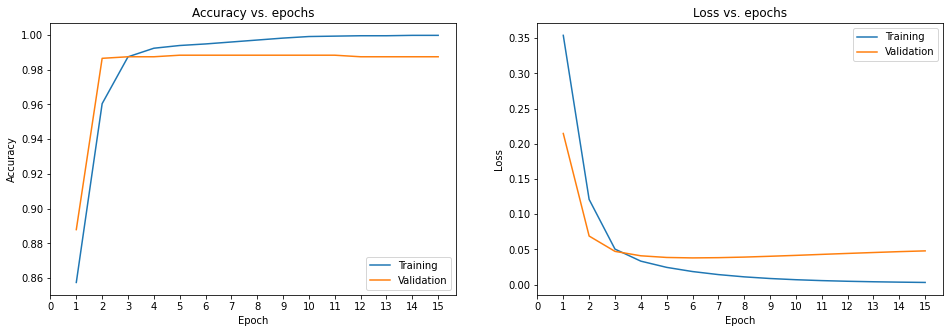

2021-09-28 07:14:08,880: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2
----------------------------------------evaluate----------------------------------------
y_score.shape=(4457, 2)
y_true.shape=(4457, 2)
len(y_true.shape)=2


2021-09-28 07:14:13,452: INFO: test loss:0.0386
2021-09-28 07:14:13,453: INFO: test accuracy:0.9883
2021-09-28 07:14:13,455: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/results.json
2021-09-28 07:14:13,457: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/results.json
2021-09-28 07:14:13,457: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/sequence_map.generator


y_score.shape=(1115, 2)
y_true.shape=(1115, 2)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------


2021-09-28 07:14:13,463: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-09-28 07:14:13,516: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/sequence_map.layer/assets


2021-09-28 07:14:14,808: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/sequence_map.layer/assets
2021-09-28 07:14:14,842: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/sequence_map.generator
2021-09-28 07:14:14,843: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/pg_snps_simple


----------------------------------------confusion matrix----------------------------------------


2021-09-28 07:14:22,168: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/sequence_map.generator


2021-09-28 07:14:22,627: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


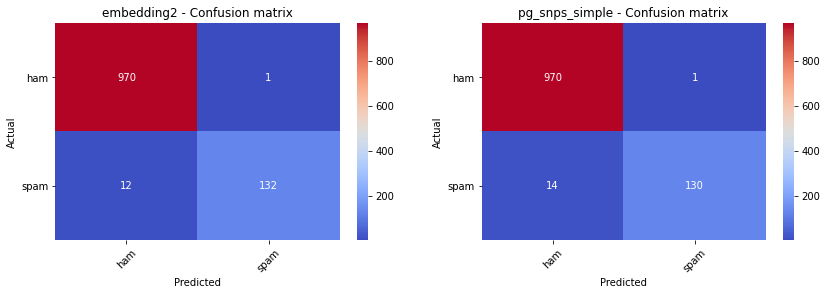

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding2,spam_tf_0927.ipynb,200802,17.8,2021-09-28 07:14,0.0193,0.0386,0.9946,0.9883,0.9996,0.9967
2,pg_snps_simple,spam_tf_0927.ipynb,484002,39.3,2021-09-28 06:22,0.0335,0.0469,0.9890,0.9865,0.9974,0.9945
3,pg_ft,spam_tf_0927.ipynb,184002,83.5,2021-09-28 06:23,0.0301,0.0449,0.9906,0.9865,0.9979,0.9951
4,rnn_lstm_snps,spam_tf_0927.ipynb,1282802,58.4,2021-09-28 06:21,0.1540,0.1413,0.9601,0.9632,0.9642,0.9579


In [34]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.embedding1(helper, name='embedding2', binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding bert

仅仅使用bert的tokenizer。

In [44]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=bert_datasets1)
# model = qtf.classification.text_models.embedding1(helper, name='embedding-bert', binary_flag=params.binary_flag) 
# model.summary()
# history = helper.train(model, callbacks=[]) 
# helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

In [ ]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
# model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm', binary_flag=params.binary_flag) 
# model.summary()
# history = helper.train(model, epochs=10)
# helper.model_summary(model, history=history)

#### rnn_lstm_fasttext

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.lstm1(helper, name='rnn_lstm_ft',
                 embedding_matrix=embedding_matrix_fasttext,
                 is_embedding_trainable=False,
                 mask_zero=False, binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_simple', binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

#### pg_fasttext

In [ ]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.text_models.pooled_gru1(helper, name='pg_ft',  
                       embedding_matrix=embedding_matrix_fasttext, 
                       is_embedding_trainable=False, binary_flag=params.binary_flag) 
model.summary()
history = helper.train(model, epochs=20)
helper.model_summary(model, history=history)

### BERT

#### bert simple

In [61]:
def bert_simple(helper, pretrained_model_name_or_path, name='bert', binary_flag=False, last_activation=None):
    dense_unit = 1 if binary_flag else len(helper.params.classes)
    
    bmodel = TFBertModel.from_pretrained(pretrained_model_name_or_path)
    input_shape = helper.datasets.train_dataset.element_spec[0].shape[1:]
    inputs = Input(shape=input_shape, dtype="int32") 
    x = bmodel(inputs)[1] 
    x = helper.get_dense_layer(dense_unit, activation=last_activation)(x)
    model = Model(inputs=inputs, outputs=x, name=name) 
    helper.compile(model)
    return model

helper = qtf.classification.Classification(params, model_results=model_results, datasets=bert_datasets1)
model = bert_simple(helper, params.pretrained_models.bert_base_uncased, name='bert-simple')
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


2021-09-28 08:09:19,671: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:09:19,769: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
2021-09-28 08:09:21,734: INFO: learning_rate=0.001
2021-09-28 08:09:21,735: INFO: model_params.bert-simple.clip_value=None
2021-09-28 08:09:21,749: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/bert-simple
2021-09-28 08:09:21,775: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/bert-simple, monitor=val_accuracy)
2021-09-28 08:09:21,776: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-09-28 08:09:21,776: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-09-28 08:09:21,777: INFO: use LearningRateScheduler()
2021-09-28 08:09:21,778: INFO: steps_per_epoch=None
2021-09-28 08:09:21,778: INFO: start training
2021-09-28 08:09:21,779: INFO: use_class_w

Model: "bert-simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64)]              0         
_________________________________________________________________
tf_bert_model_8 (TFBertModel TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2021-09-28 08:09:21,839: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:09:21,932: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:09:26,805: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:09:26,902: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


139/139 [==============================] - ETA: 0s - loss: 0.4877 - accuracy: 0.8514WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:10,922: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:11,028: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


139/139 [==============================] - 122s 793ms/step - loss: 0.4877 - accuracy: 0.8514 - val_loss: 0.3856 - val_accuracy: 0.8709


2021-09-28 08:11:24,272: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:24,379: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:27,487: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:27,488: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:30,406: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:30,407: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:34,530: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:34,630: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:37,673: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:37,771: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:43,374: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:43,475: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:45,832: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:45,930: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:49,529: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:49,630: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:51,965: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:52,063: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:54,579: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:54,678: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:57,090: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:57,187: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:11:59,778: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:11:59,875: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:12:03,341: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:12:03,343: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:12:05,637: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:12:05,639: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
2021-09-28 08:12:10,714: WARNING: Found untraced functions such as embeddings_layer_call_fn, embeddings_layer_call_and_return_conditional_losses, encoder_layer_call_fn, encoder_layer_call_and_return_conditional_losses, pooler_layer_call_fn while saving (showing 5 of 1055). These functions will not be directly callable after loading.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/bert-simple/assets


2021-09-28 08:12:21,908: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/bert-simple/assets


Epoch 2/10
139/139 [==============================] - 106s 767ms/step - loss: 0.4116 - accuracy: 0.8647 - val_loss: 0.3848 - val_accuracy: 0.8709
Epoch 3/10
139/139 [==============================] - 107s 767ms/step - loss: 0.4121 - accuracy: 0.8647 - val_loss: 0.3850 - val_accuracy: 0.8709
Epoch 4/10


2021-09-28 08:15:56,881: INFO: finish training [elapsed time: 395.10 seconds]


KeyboardInterrupt: 

#### bert lstm

In [71]:

def bert_lstm1(helper, pretrained_model_name_or_path, name='rnn_lstm',
          dropout=None,
          last_activation=None,
          binary_flag=False):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    units = helper.params.get_model_param(name, 'units')
    input_shape = helper.datasets.train_dataset.element_spec[0].shape[1:]
    
    bmodel = TFBertModel.from_pretrained(pretrained_model_name_or_path)
    inputs = layers.Input(shape=input_shape, dtype="int32")
    x = bmodel(inputs)[0] 
    rnn_layer_units= 128 
    if dropout > 0:
        x = layers.SpatialDropout1D(dropout)(x)
    x = layers.Bidirectional(layers.GRU(rnn_layer_units, return_sequences=True))(x)
    for i in range(1):
        x = layers.GRU(rnn_layer_units, return_sequences=True)(x)

    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    dense_unit = 1 if binary_flag else len(helper.params.classes)
    x = helper.get_dense_layer(dense_unit, activation=last_activation)(x)
    model = Model(inputs=inputs, outputs=x, name=name)
    helper.compile(model)
    return model

helper = qtf.classification.Classification(params, model_results=model_results, datasets=bert_datasets1)
model = bert_lstm1(helper, params.pretrained_models.bert_base_uncased, name='bert-lstm1')
model.summary()
history = helper.train(model, epochs=10)
helper.model_summary(model, history=history)

2021-09-28 08:23:37,293: INFO: dropout=0.1
2021-09-28 08:23:37,295: INFO: model_params.bert-lstm1.units=None
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


2021-09-28 08:23:41,050: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:23:41,148: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
2021-09-28 08:23:43,915: INFO: learning_rate=0.001
2021-09-28 08:23:43,916: INFO: model_params.bert-lstm1.clip_value=None
2021-09-28 08:23:43,929: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/bert-lstm1
2021-09-28 08:23:43,952: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/bert-lstm1, monitor=val_accuracy)
2021-09-28 08:23:43,953: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-09-28 08:23:43,953: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-09-28 08:23:43,954: INFO: use LearningRateScheduler()
2021-09-28 08:23:43,954: INFO: steps_per_epoch=None
2021-09-28 08:23:43,955: INFO: start training
2021-09-28 08:23:43,956: INFO: use_class_weig

Model: "bert-lstm1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_16 (TFBertModel)  TFBaseModelOutputWit 109482240   input_19[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 64, 768)      0           tf_bert_model_16[0][0]           
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 64, 256)      689664      spatial_dropout1d_2[0][0]        
_________________________________________________________________________________________

2021-09-28 08:23:44,006: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:23:44,096: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:23:48,503: WARNING: Gradients do not exist for variables ['tf_bert_model_16/bert/pooler/dense/kernel:0', 'tf_bert_model_16/bert/pooler/dense/bias:0'] when minimizing the loss.


2021-09-28 08:23:50,898: WARNING: The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2021-09-28 08:23:50,999: WARNING: The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


2021-09-28 08:23:55,406: WARNING: Gradients do not exist for variables ['tf_bert_model_16/bert/pooler/dense/kernel:0', 'tf_bert_model_16/bert/pooler/dense/bias:0'] when minimizing the loss.
2021-09-28 08:24:00,141: INFO: finish training [elapsed time: 16.19 seconds]


InternalError:    Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 3, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 256, 128, 1, 64, 32, 0] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[Adam/gradients/PartitionedCall]] [Op:__inference_train_function_321002]

Function call stack:
train_function -> train_function -> train_function


## 模型评估

### 预测更新

In [59]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 

2021-09-28 06:25:28,115: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf
2021-09-28 06:25:28,116: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/results.json


In [60]:
data_model_results.get_top_n(10, mode='df').columns

Index(['model_name', 'data_name', 'program_name', 'program_path',
       'weight_number', 'classes', 'train_time', 'model_path',
       'generator_path', 'create_time', 'train_loss', 'test_loss',
       'train_accuracy', 'test_accuracy', 'train_auc', 'test_auc'],
      dtype='object')

In [61]:
data_model_results.show(5, columns=['test_loss', 'test_accuracy', 'model_path'])

,test_loss,test_accuracy,model_path
1,0.0382,0.9892,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/4...
2,0.0469,0.9865,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/4...
3,0.0449,0.9865,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/4...
4,0.1413,0.9632,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/4...


In [62]:
predictor = qtf.classification.Predictor.get_best_predictor(data_model_results)
# result_path = os.path.join(params.data_path, '{}_prediction.txt'.format(params.data_name))
# error_sample_path = os.path.join(params.data_path, '{}_error_sample.csv'.format(params.data_name))

# df_results, df_error_sample = qtf.text.save_predictions(reviews_df, 
#                                                         params.text_columns, 
#                                                         predictor,   
#                                                         result_path=result_path, 
#                                                         error_sample_path=error_sample_path,
#                                                         top_n=2
#                                                        )
# display(df_results.tail(5))
# print('-'*50)
# print(df_error_sample.groupby('label').size())
# print('-'*50)
# print(df_error_sample.groupby('top2_predict_correct').size())

2021-09-28 06:25:30,117: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/embedding2
2021-09-28 06:25:30,396: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/45-nlp/spacy/mastering_spacy/output/spam_tf/spam_tf_0927/sequence_map.generator


2021-09-28 06:25:30,730: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


### 更多Metrics

In [63]:
predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 
                                 metrics.SparseTopKCategoricalAccuracy(k=2),
                                 'mae'])

results = predictor.evaluate(test_texts, test_labels)
print(results)

predictions = predictor.predict(test_texts)
print(predictions.shape)

{'loss': 0.03820886090397835, 'accuracy': 0.9892376661300659, 'sparse_top_k_categorical_accuracy': 1.0, 'mae': 3.222216844558716}
(1115, 2)


In [64]:
top1_predictions = predictor.predict_top_k(test_texts, test_labels, top_k=1)
top2_predictions = predictor.predict_top_k(test_texts, test_labels, top_k=2)

top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
top2_scores = qtf.utils.score(test_labels, top2_predictions, params.classes)

display(top1_scores)
# print('-'*100)
# display(top2_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))
# print('-'*100)
# print(classification_report(test_labels, top2_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
ham,0.989785,0.997940,0.993846
spam,0.985294,0.930556,0.957143


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         ham     0.9898    0.9979    0.9938       971
        spam     0.9853    0.9306    0.9571       144

    accuracy                         0.9892      1115
   macro avg     0.9875    0.9642    0.9755      1115
weighted avg     0.9892    0.9892    0.9891      1115



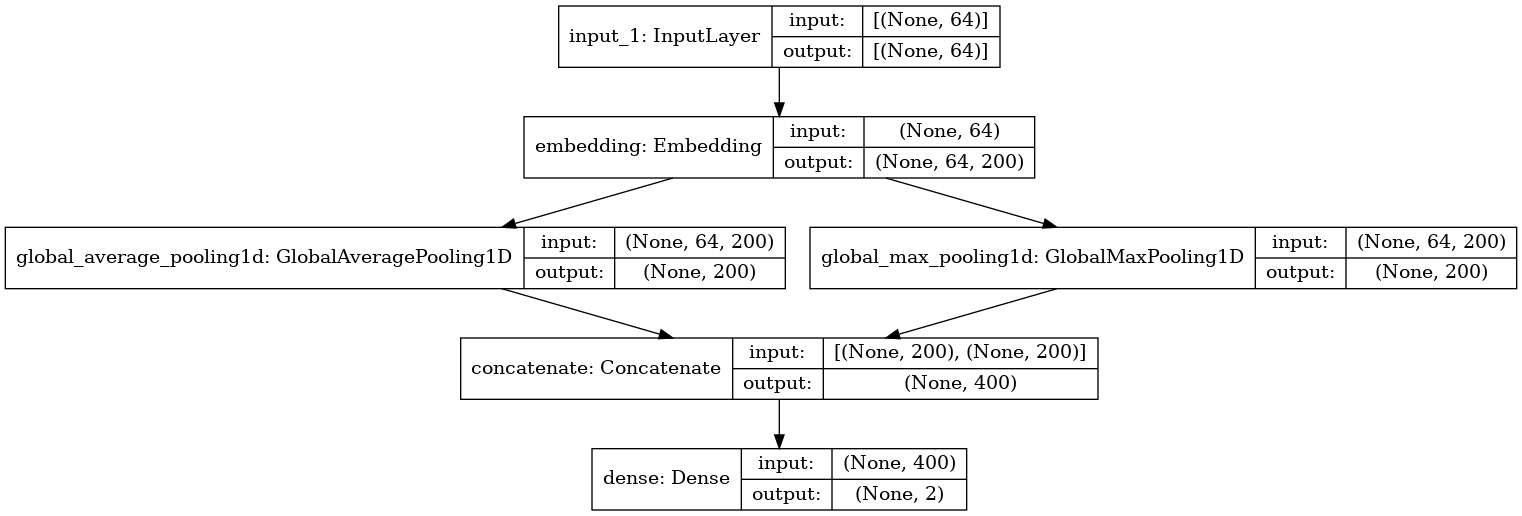

In [66]:
qtf.utils.plot_model_structure(predictor.model)